#Setup

Import common packages

In [1]:
%%capture
import argparse, datetime
from functools import reduce
import glob
import itertools as it
from multiprocessing import cpu_count, Pool
import networkx as nx
import numpy as np
import os

#in environments where the pickle and pandas modules are incompatible...
!pip install pandas==1.5

import pandas as pd
import pickle
import math
import matplotlib.pyplot as plt
import random, re, shutil
from scipy.stats import hmean
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression
import sklearn.metrics
from sklearn.metrics import auc, average_precision_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import subprocess as sp
import sys
import tempfile as tf
import time
from tqdm import tqdm as progressMonitor

Enable Google Colab, mount drives, and load/define proprietary modules

In [2]:
%%capture
from google.colab import drive, files, output
drive.mount('/content/drive', force_remount=True)
!rm -r sample_data/

In [3]:
#useful to keep track of sys vars so as to better monitor space remaining
print(cpu_count())
sysVars = list(globals().keys())

96


Define directories and principal object paths

In [4]:
rootDir = '/content/drive/MyDrive/'
workDir = rootDir + 'elcfs_protein_complex_modeling/' #phase2 directory
workDir_elcfs = rootDir + 'proteinPairs_complexMaps/' #modeling library
workDir_ph1 = rootDir + 'Primary Research/JLMwSCBC_notebook/' #phase 1 directory
workDir_other = rootDir + 'otherStudies/'

sys.path.insert(0, rootDir)
for p in workDir, workDir_elcfs, workDir_ph1, workDir_other: sys.path.append(p)

In [5]:
from util import modelEvaluating
from utils import operations, reference, alertMe
pushoverKey_user = 'uith8rmy2npjj1oqpjwcanow3un984'
pushoverAPI = 'aw4v3424kaznrw598r6qge9icddwg7'

In [6]:
#be careful if using this pkg; models generated using prior SciKit release
## suppress warnings since we know it's behind the current release
import warnings
warnings.filterwarnings('ignore')

In [7]:
setupDir = workDir + 'setup/'
refDir = workDir + 'srcData/'
ph1Model_perfDir = workDir_ph1 + 'modelPerformance/'
shortcutDir = workDir + 'google_colab_notebooks/notebookQC/'

#Alert tool

In [ ]:
#copy the contents between the ellipses into the cell subsequent to that for
# which the run time is long
'''
#put this block after any cell expected to take a long time
cmdReport = alertMe.statusCheck(pushoverAPI, pushoverKey_user)
cmdReport.finishPush()
'''

#Load partition feature matrices with pair IDs and labels, model-partition arrays, model properties reference files, and original predictions

In [ ]:
#specify directories for models, fold separated feature matrices, and
##use glob for extracting complete (long) filenames
expName = 'fullSet_D17+LM+AF+SCBC'
dataDir = workDir_ph1 + 'dataPartitions/{0}*/'.format(expName)
modelsDir = workDir_ph1 + 'models/*{0}*/'.format(expName)
modelsDir_perf = workDir_ph1 + 'modelPerformance/*{0}*/'.format(expName)

pairsInfo = \
  {fold: pd.read_csv(f, sep='\t', header=0, names=['id1', 'id2'], dtypes='str')
  for fold, f in enumerate(sorted(glob.glob(dataDir + '*testPairs.tsv')))}
pairsInfo = \
  {fold: operations.freezePairs(df, pool=True)
  for fold, df in pairsInfo.items()}
featMats = \
  {fold: pd.read_csv(f, sep='\t')
  for fold, f in enumerate(sorted(glob.glob(dataDir + '*testData.tsv')))}
featMats_notnull = {fold: df.notnull() for fold, df in featMats.items()}
labels = \
  {fold: pd.read_csv(f, sep='\t')
  for fold, f in enumerate(sorted(glob.glob(dataDir + '*testLabels.tsv')))}

savedPartitions = pickle.load(open(modelsDir + 'savedPartitions.pkl', 'rb'))
modelsProperties = \
  {fold: pd.read_csv(f)
  for fold, f in enumerate(sorted(glob.glob(modelsDir + '*Performance*')))}

modelsPerfs = \
  {fold: pd.read_csv(f, dtype={'num features': 'float64'})
  for fold, f in enumerate(sorted(glob.glob(modelsDir_perf + '*Performance*')))}
predsProbs = \
  {fold: pd.read_csv(f, names=['score'])
  for fold, f in enumerate(sorted(glob.glob(modelsDir_perf + 'probsPos-weig*')))}

#Automate prediction generation using ELCFS modeling library

In [ ]:
def predict(prtns, modelsProps, data, labels, pairs, name,
            suffix='', return_prr=False):

  candPrtns, candPrtns_preds, \
    candPrtns_predsProbs, modelsPerf_props = \
      modelEvaluating.evalPartitions(prtns, modelsProps, data, labels, dir, name,
                                     suffix=suffix)

  probsAcc, probsWeighted, labelsAdj = \
      modelEvaluating.evalTotal(candPrtns, candPrtns_preds, modelsPerf_props,
                                labels, dir, name, suffix=suffix)

  pAcc, rAcc, pWeighted, rWeighted = \
    modelEvaluating.evalSummary(probsAcc, probsWeighted, labelsAdj, dir, name,
                                suffix=suffix)

  predProbs_newFilename = \
    glob.glob(modelsDir_perf + 'probsPos-weig*{0}'.format(suffix))[0]
  predProbs = pd.concat(
      [pairs, pd.read_csv(predProbs_newFilename, names=['score'])], axis=1)

  if return_prr:
    return predProbs, pAcc, rAcc, pWeighted, rWeighted
  else:
    return predProbs

#Make substitutions for NCI-60 RNA and protein correlation features

In [ ]:
#Make single-value substitutions for each NCI-60 feature, individually and generate predictions
##should have 6 sets of predictions

predProbs_featMat_indSubs = {}
for featCol in ['262', '263']:
  for var in [-1, 0, 1]:
    probsConcat = []
    for fold, featMat in featMat.items():
      subsPair_name = ', '.join([featCol, str(var)])
      print('Substitution value: {0}'.format(subsPair_name))

      featMat_substitution = featMat.copy()
      featMat_substitution.loc[:, featCol] = var
      probsConcat.append(
          predict(savedPartitions, modelsProperties[fold],
                  featMat_substitution, labels[fold], pairsInfo[fold],
                  expName, suffix=subsPair_name))

    predProbs_featMat_indSubs[', '.join([featCol, str(var)])] = \
      np.concatenate(probsConcat)

In [ ]:
#Make single-value substitutions for both NCI-60 features, jointly, and generate predictions
##should have 9 sets of predictions

predProbs_featMat_jointSubs = {}
singleVal_subsPairs = list(it.product([-1, 0, 1], [-1, 0, 1]))
for subsPair in singleVal_subsPairs[:3]:
  probsConcat = []
  for fold, featMat in featMat.items():
    subsPair_name = ', '.join([str(j) for j in subsPair])
    print('Substitution values: {0}'.format(subsPair))

    featMat_substitution = featMat.copy()
    featMat_substitution.loc[:, '262'] = subsPair[0]
    featMat_substitution.loc[:, '263'] = subsPair[1]
    probsConcat.append(
        predict(savedPartitions, modelsProperties[fold],
                featMat_substitution, labels[fold], pairsInfo[fold],
                expName, suffix=subsPair_name))

  predProbs_featMat_jointSubs[subsPair_name] = \
    np.concatenate(probsConcat)

#Concatenate predictions for comparison and analysis

In [ ]:
#construct dictionary for storing all the results from
#the feature substitution experiments
predProbs_nci60Subs = dict()

for k, v in predProbs_featMat_indSubs.items():
  predProbs_nci60Subs[k] = v

for k, v in predProbs_featMat_jointSubs.items():
  predProbs_nci60Subs[k] = v

In [24]:
predProbs_nci60Subs_filename = \
  shortcutDir + 'predProbs_nci60Feat_featMat_subsTesting.pkl'

#save output, results
#pickle.dump(predProbs_nci60Subs, open(predProbs_nci60Subs_filename, 'wb'))

#load results
predProbs_nci60Subs = pickle.load(open(predProbs_nci60Subs_filename, 'rb'))

In [27]:
#create DFs for each of the following:
##only 1 feature was varied
##both features were varied together together
##all combined
featVaried_singleCols = \
  ['262, -1', '262, 0', '262, 1', '263, -1', '263, 0', '263, 1']
featVaried_jointCols = \
  ['0, -1', '0, 0', '0, 1', '1, -1', '1, 0', '1, 1', '-1, -1', '-1, 0', '-1, 1']

featVaried_single = \
  pd.concat(
      [predProbs_nci60Subs['orig'].rename(columns={'score': 'orig'}),
       pd.concat([predProbs_nci60Subs[k].rename(columns={'score': k})[k]
                  for k in featVaried_singleCols],
                 axis=1)], axis=1)

featVaried_joint = \
  pd.concat(
      [predProbs_nci60Subs['orig'].rename(columns={'score': 'orig'}),
       pd.concat([predProbs_nci60Subs[k].rename(columns={'score': k})[k]
                  for k in featVaried_jointCols],
                 axis=1)], axis=1)

featVaried_all = \
  pd.concat(
      [predProbs_nci60Subs['orig'].rename(columns={'score': 'orig'}),
       pd.concat([predProbs_nci60Subs[k].rename(columns={'score': k})[k]
                  for k in featVaried_singleCols + featVaried_jointCols],
                 axis=1)], axis=1)

In [14]:
#transform DF for simpler plotting operations,
##e.g., comparing changes to original, so make new columns:
##(1) representing what was varied (and to what value) and
##(1) corresponding to the score, so that the new scores can be grouped by kind
featVaried_single = \
  pd.melt(featVaried_single, id_vars=['id1', 'id2', 'pairsFrozen', 'orig'],
          var_name='featVaried,subsVal', value_name='score')
featVaried_single

,id1,id2,pairsFrozen,orig,"featVaried,subsVal",score
0,27316,9939,"(9939, 27316)",0.111394,"262, -1",0.000000
1,10450,3550,"(10450, 3550)",0.408077,"262, -1",0.624941
2,23450,10155,"(10155, 23450)",0.142494,"262, -1",0.000000
3,9343,94104,"(9343, 94104)",0.674392,"262, -1",0.875076
4,22826,6634,"(6634, 22826)",0.034361,"262, -1",0.000000
...,...,...,...,...,...,...
1228657,6840,4171,"(4171, 6840)",0.001250,"263, 1",0.000000
1228658,10226,63931,"(63931, 10226)",0.001874,"263, 1",0.000000
1228659,2071,11066,"(11066, 2071)",0.010623,"263, 1",0.000000
1228660,2932,84515,"(84515, 2932)",0.011876,"263, 1",0.125022


In [15]:
featVaried_joint = \
  pd.melt(featVaried_joint, id_vars=['id1', 'id2', 'pairsFrozen', 'orig'],
          var_name='featVaried,subsVal', value_name='score')
featVaried_joint

,id1,id2,pairsFrozen,orig,"featVaried,subsVal",score
0,27316,9939,"(9939, 27316)",0.111394,"0, -1",0.000000
1,10450,3550,"(10450, 3550)",0.408077,"0, -1",0.374879
2,23450,10155,"(10155, 23450)",0.142494,"0, -1",0.000000
3,9343,94104,"(9343, 94104)",0.674392,"0, -1",0.750108
4,22826,6634,"(6634, 22826)",0.034361,"0, -1",0.000000
...,...,...,...,...,...,...
1842988,6840,4171,"(4171, 6840)",0.001250,"-1, 1",0.000000
1842989,10226,63931,"(63931, 10226)",0.001874,"-1, 1",0.000000
1842990,2071,11066,"(11066, 2071)",0.010623,"-1, 1",0.000000
1842991,2932,84515,"(84515, 2932)",0.011876,"-1, 1",0.125022


In [16]:
#find corr b2n original scores and new scores &
##rename DF columns, inserting corr, to aid informativeness of subsequent plots
corrMapping_featVaried_single = \
  {k: k + ' corr: {0}'.format(
      np.round(
          featVaried_single.loc[featVaried_single['featVaried,subsVal']==k,
           ['orig', 'score']].corr().loc['orig', 'score'], 3))
  for k in featVaried_single['featVaried,subsVal'].unique()}

featVaried_single['featVaried,subsVal'] = \
  featVaried_single['featVaried,subsVal'].replace(corrMapping_featVaried_single)

In [17]:
corrMapping_featVaried_joint = \
  {k: k + ' corr: {0}'.format(
      np.round(
          featVaried_joint.loc[featVaried_joint['featVaried,subsVal']==k,
           ['orig', 'score']].corr().loc['orig', 'score'], 3))
  for k in featVaried_joint['featVaried,subsVal'].unique()}

featVaried_joint['featVaried,subsVal'] = \
  featVaried_joint['featVaried,subsVal'].replace(corrMapping_featVaried_joint)

#Results

>   Col 262: RNA

>   Col: 263: Protein

>   featVaried_singleCols

*   RNA => -1, orig Prot
*   RNA => 0, orig Prot
*   RNA => 1, orig Prot
*   orig RNA, Prot => -1
*   orig RNA, Prot => 0
*   orig RNA, Prot => 1


>   featVaried_jointCols

*   RNA => 0, Prot => -1
*   RNA => 0, Prot => 0
*   RNA => 0, Prot => 1
*   RNA => 1, Prot => -1
*   RNA => 1, Prot => 0
*   RNA => 1, Prot => 1
*   RNA => -1, Prot => -1
*   RNA => -1, Prot => 0
*   RNA => -1, Prot => 1


##Original

In [ ]:
#statistics summary for predictions from feats
##made by substituting 1 feature
featVaried_all.describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_singleCols]

,orig,"262, -1","262, 0","262, 1","263, -1","263, 0","263, 1"
mean,0.025623,0.006197,0.004585,0.041277,0.009969,0.003919,0.023818
std,0.061421,0.063061,0.056587,0.116503,0.069050,0.051982,0.105725
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#statistics summary for predictions from feats
##made by substituting both features
featVaried_all.describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_jointCols]

,orig,"0, -1","0, 0","0, 1","1, -1","1, 0","1, 1","-1, -1","-1, 0","-1, 1"
mean,0.025623,0.005003,0.003496,0.021708,0.021675,0.064687,0.053931,0.029586,0.004191,0.019398
std,0.061421,0.056020,0.049692,0.103042,0.095167,0.133486,0.144221,0.107279,0.053542,0.100305
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#select fraction of pairs to be randomly selected for viewability, readability of plots
sampFrac = 0.001

In [ ]:
#plot the original scores against those of the most different (or least correlated)
#which correspond to the feature substitutions of greatest effect
##features varied individually
featVaried_single['featVaried,subsVal'].unique()

array(['262, -1 corr: 0.859', '262, 0 corr: 0.851', '262, 1 corr: 0.542',
       '263, -1 corr: 0.671', '263, 0 corr: 0.823', '263, 1 corr: 0.717'],
      dtype=object)

<Axes: xlabel='orig', ylabel='score'>

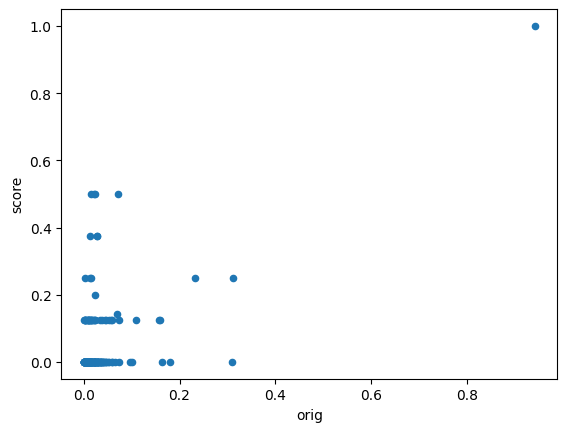

In [ ]:
featVaried_single.loc[
    featVaried_single['featVaried,subsVal']=='262, 1 corr: 0.542'].sample(
        frac=sampFrac).plot.scatter(x='orig', y='score')

In [ ]:
#plot the original scores against those of the most different (or least correlated)
#which correspond to the feature substitutions of greatest effect
##features varied jointly
featVaried_joint['featVaried,subsVal'].unique()

array(['0, -1 corr: 0.79', '0, 0 corr: 0.803', '0, 1 corr: 0.715',
       '1, -1 corr: 0.65', '1, 0 corr: 0.446', '1, 1 corr: 0.575',
       '-1, -1 corr: 0.416', '-1, 0 corr: 0.815', '-1, 1 corr: 0.758'],
      dtype=object)

<Axes: xlabel='orig', ylabel='score'>

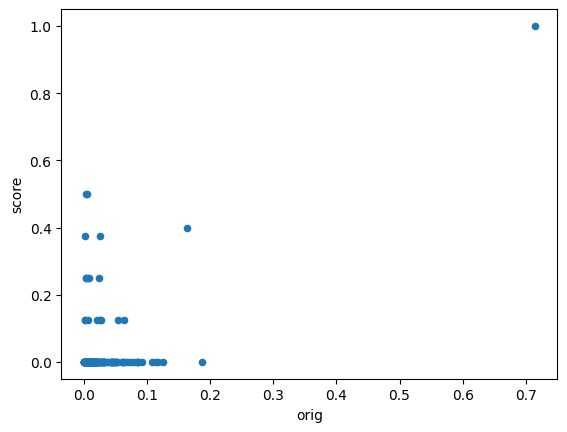

In [ ]:
featVaried_joint.loc[
    featVaried_joint['featVaried,subsVal']=='-1, -1 corr: 0.416'].sample(
        frac=sampFrac).plot.scatter(x='orig', y='score')

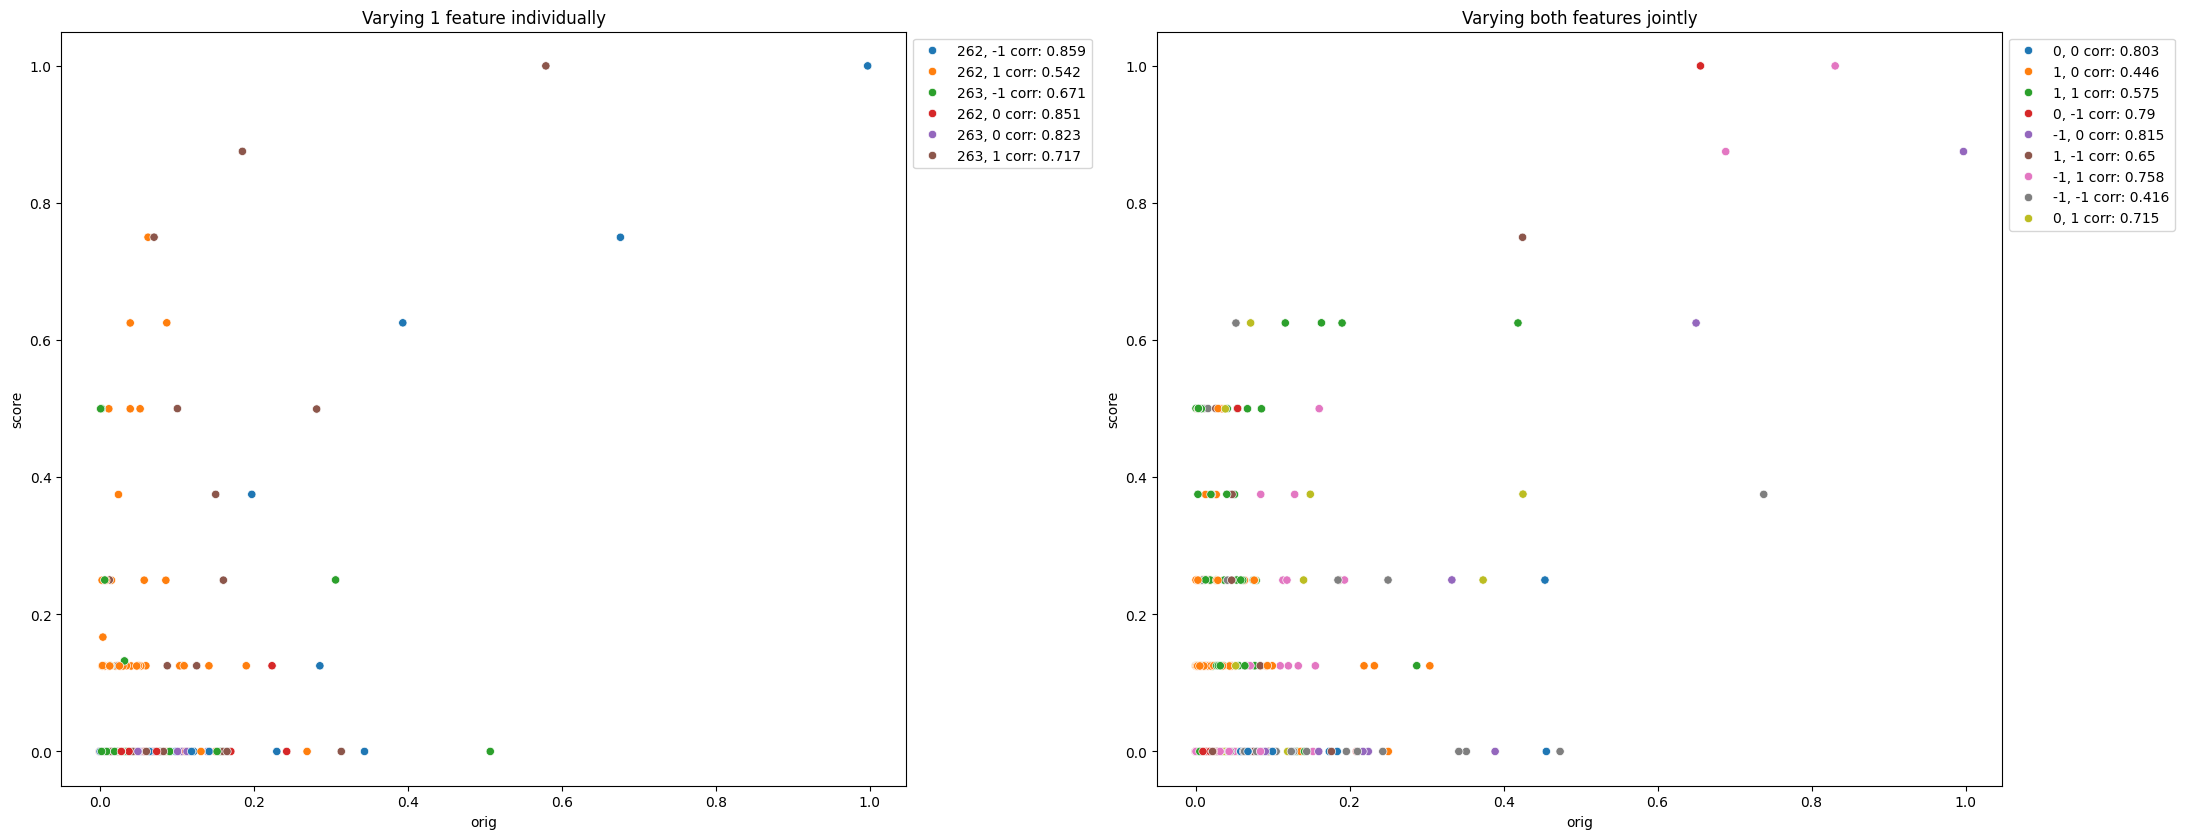

In [ ]:
f, axs = plt.subplots(1, 2, figsize=(24, 12))
f.tight_layout(pad=15)
axs[0].set_title('Varying 1 feature individually')
sns.scatterplot(data=featVaried_single.sample(frac=sampFrac),
                x='orig', y='score', hue='featVaried,subsVal', ax=axs[0])
axs[0].legend(bbox_to_anchor=(1, 1), loc=2)

axs[1].set_title('Varying both features jointly')
sns.scatterplot(data=featVaried_joint.sample(frac=sampFrac),
                x='orig', y='score', hue='featVaried,subsVal', ax=axs[1])
axs[1].legend(bbox_to_anchor=(1, 1), loc=2)

##Segregated by availability of non-expression data-based features

>   pairs for which non-expression data-based features were available generally show higher means, mins, and maxs; although the stds are comparable

>   pairs for which non-expression data-based features were available generally show higher means, mins, and maxs; the stds are also greater, however, the extent to which they are greater vary by feature substitution with orders of magnitude

>   **most surprisingly, the data shows that predictions on pairs for which non-expression data-based features were available had greater sensitivity to changes with the NCI-60 features than those pairs for which only expression data was available**

In [9]:
elcfsPairs_featSegregated_filename = \
  rootDir + 'expsetPairs_protLevel_pair+protLeveL_segregated.pkl'
elcfsPairs_featSegregated = \
  pickle.load(open(elcfsPairs_featSegregated_filename, 'rb'))
elcfsPairs_protLevel_featOnly = \
  elcfsPairs_featSegregated['elcfsPairs_protLevel_featOnly']
elcfsPairs_pairLevel_featAvail = \
  elcfsPairs_featSegregated['elcfsPairs_pairLevel_featAvail']

In [30]:
#statistics summary for predictions from feats
##made by substituting 1 feature
###non-expression data available
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_pairLevel_featAvail)].describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_singleCols]

,orig,"262, -1","262, 0","262, 1","263, -1","263, 0","263, 1"
mean,0.029916,0.008923,0.006781,0.042160,0.011908,0.005820,0.029178
std,0.072853,0.076315,0.068979,0.122864,0.078511,0.063444,0.119391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [31]:
#statistics summary for predictions from feats
##made by substituting 1 feature
###only expression data available
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_protLevel_featOnly)].describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_singleCols]

,orig,"262, -1","262, 0","262, 1","263, -1","263, 0","263, 1"
mean,0.017059,0.000758,0.000205,0.039515,0.006102,0.000125,0.013124
std,0.024490,0.015701,0.008291,0.102616,0.044273,0.006406,0.069772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.618414,0.875016,0.750055,1.000000,0.875232,0.750050,1.000000


In [32]:
#statistics summary for predictions from feats
##made by substituting both features
###non-expression data available
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_pairLevel_featAvail)].describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_jointCols]

,orig,"0, -1","0, 0","0, 1","1, -1","1, 0","1, 1","-1, -1","-1, 0","-1, 1"
mean,0.029916,0.007462,0.005230,0.026647,0.025875,0.061263,0.062518,0.029211,0.006212,0.025162
std,0.072853,0.068374,0.060756,0.116412,0.107072,0.136414,0.157188,0.108966,0.065351,0.116290
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [33]:
#statistics summary for predictions from feats
##made by substituting both features
###only expression data available
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_protLevel_featOnly)].describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_jointCols]

,orig,"0, -1","0, 0","0, 1","1, -1","1, 0","1, 1","-1, -1","-1, 0","-1, 1"
mean,0.017059,0.000095,0.000037,0.011853,0.013296,0.071519,0.036797,0.030334,0.000157,0.007898
std,0.024490,0.005973,0.003642,0.067953,0.064404,0.127170,0.112075,0.103829,0.006413,0.054356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.618414,0.625039,0.625014,1.000000,0.875076,1.000000,1.000000,0.875076,0.750050,1.000000


In [27]:
#select fraction of pairs to be randomly selected for viewability, readability of plots
sampFrac = 0.001

In [ ]:
#statistics summary for predictions from feats
##made by substituting 1 feature

>   pairs for which non-expression data-based features were available generally show higher means, mins, and maxs; although the stds are comparable

In [23]:
###expression-only data feats
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_protLevel_featOnly)].describe().loc[
        ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_singleCols]

,orig,"262, -1","262, 0","262, 1","263, -1","263, 0","263, 1"
mean,0.017059,0.000758,0.000205,0.039515,0.006102,0.000125,0.013124
std,0.024490,0.015701,0.008291,0.102616,0.044273,0.006406,0.069772
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.618414,0.875016,0.750055,1.000000,0.875232,0.750050,1.000000


In [24]:
###expression, non-expression data feats
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_pairLevel_featAvail)].describe().loc[
        ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_singleCols]

,orig,"262, -1","262, 0","262, 1","263, -1","263, 0","263, 1"
mean,0.029916,0.008923,0.006781,0.042160,0.011908,0.005820,0.029178
std,0.072853,0.076315,0.068979,0.122864,0.078511,0.063444,0.119391
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
#statistics summary for predictions from feats
##made by substituting both features

>   pairs for which non-expression data-based features were available generally show higher means, mins, and maxs; the stds are also greater, however, the extent to which they are greater vary by feature substitution with orders of magnitude

In [25]:
###expression-only data feats
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_protLevel_featOnly)].describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_jointCols]

,orig,"0, -1","0, 0","0, 1","1, -1","1, 0","1, 1","-1, -1","-1, 0","-1, 1"
mean,0.017059,0.000095,0.000037,0.011853,0.013296,0.071519,0.036797,0.030334,0.000157,0.007898
std,0.024490,0.005973,0.003642,0.067953,0.064404,0.127170,0.112075,0.103829,0.006413,0.054356
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.618414,0.625039,0.625014,1.000000,0.875076,1.000000,1.000000,0.875076,0.750050,1.000000


In [26]:
###expression, non-expression data feats
featVaried_all.loc[featVaried_all.pairsFrozen.isin(
    elcfsPairs_pairLevel_featAvail)].describe().loc[
    ['mean', 'std', 'min', 'max'], ['orig'] + featVaried_jointCols]

,orig,"0, -1","0, 0","0, 1","1, -1","1, 0","1, 1","-1, -1","-1, 0","-1, 1"
mean,0.029916,0.007462,0.005230,0.026647,0.025875,0.061263,0.062518,0.029211,0.006212,0.025162
std,0.072853,0.068374,0.060756,0.116412,0.107072,0.136414,0.157188,0.108966,0.065351,0.116290
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
#plot the original scores against those of the most different (or least correlated)
#which correspond to the feature substitutions of greatest effect
##features varied individually
print(featVaried_single['featVaried,subsVal'].unique())

['262, -1 corr: 0.859' '262, 0 corr: 0.851' '262, 1 corr: 0.542'
 '263, -1 corr: 0.671' '263, 0 corr: 0.823' '263, 1 corr: 0.717']


Text(0.5, 1.0, 'expression-only data feats')

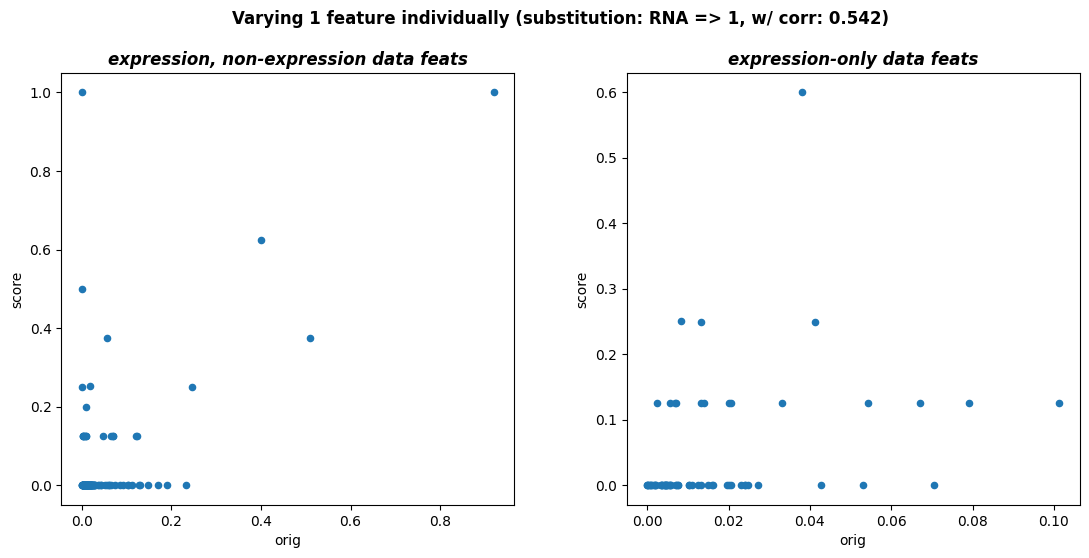

In [86]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout(pad=5)
plt.suptitle('Varying 1 feature individually ' +
             '(substitution: RNA => 1, w/ corr: 0.542)', fontweight='bold')

featVaried_single.loc[
    ((featVaried_single['featVaried,subsVal']=='262, 1 corr: 0.542') &
     (featVaried_single.pairsFrozen.isin(elcfsPairs_pairLevel_featAvail)))
    ].sample(frac=sampFrac).plot.scatter(x='orig', y='score', ax=axs[0])
axs[0].set_title('expression, non-expression data feats',
                 fontweight='bold', style='italic')

featVaried_single.loc[
    ((featVaried_single['featVaried,subsVal']=='262, 1 corr: 0.542') &
     (featVaried_single.pairsFrozen.isin(elcfsPairs_protLevel_featOnly)))
    ].sample(frac=sampFrac).plot.scatter(x='orig', y='score', ax=axs[1])
axs[1].set_title('expression-only data feats',
                 fontweight='bold', style='italic')

In [37]:
#plot the original scores against those of the most different (or least correlated)
#which correspond to the feature substitutions of greatest effect
##features varied jointly
featVaried_joint['featVaried,subsVal'].unique()

array(['0, -1 corr: 0.79', '0, 0 corr: 0.803', '0, 1 corr: 0.715',
       '1, -1 corr: 0.65', '1, 0 corr: 0.446', '1, 1 corr: 0.575',
       '-1, -1 corr: 0.416', '-1, 0 corr: 0.815', '-1, 1 corr: 0.758'],
      dtype=object)

Text(0.5, 1.0, 'expression-only data feats')

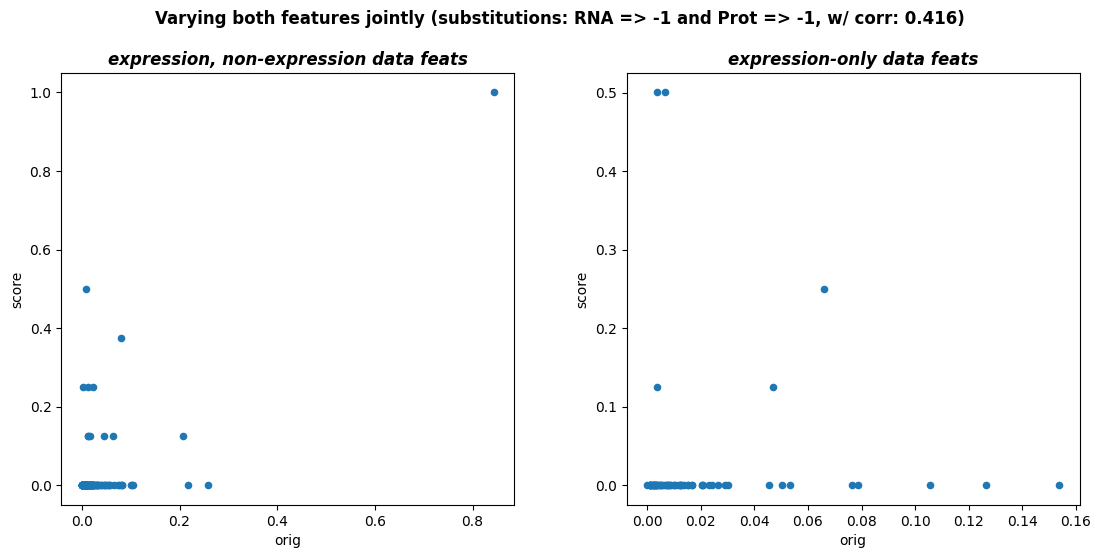

In [87]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
f.tight_layout(pad=5)
plt.suptitle('Varying both features jointly ' +
             '(substitutions: RNA => -1 and Prot => -1, w/ corr: 0.416)',
             fontweight='bold')

featVaried_joint.loc[
    ((featVaried_joint['featVaried,subsVal']=='-1, -1 corr: 0.416') &
     (featVaried_joint.pairsFrozen.isin(elcfsPairs_pairLevel_featAvail)))
    ].sample(frac=sampFrac).plot.scatter(x='orig', y='score', ax=axs[0])
axs[0].set_title('expression, non-expression data feats',
                 fontweight='bold', style='italic')

featVaried_joint.loc[
    ((featVaried_joint['featVaried,subsVal']=='-1, -1 corr: 0.416') &
     (featVaried_joint.pairsFrozen.isin(elcfsPairs_protLevel_featOnly)))
    ].sample(frac=sampFrac).plot.scatter(x='orig', y='score', ax=axs[1])
axs[1].set_title('expression-only data feats',
                 fontweight='bold', style='italic')

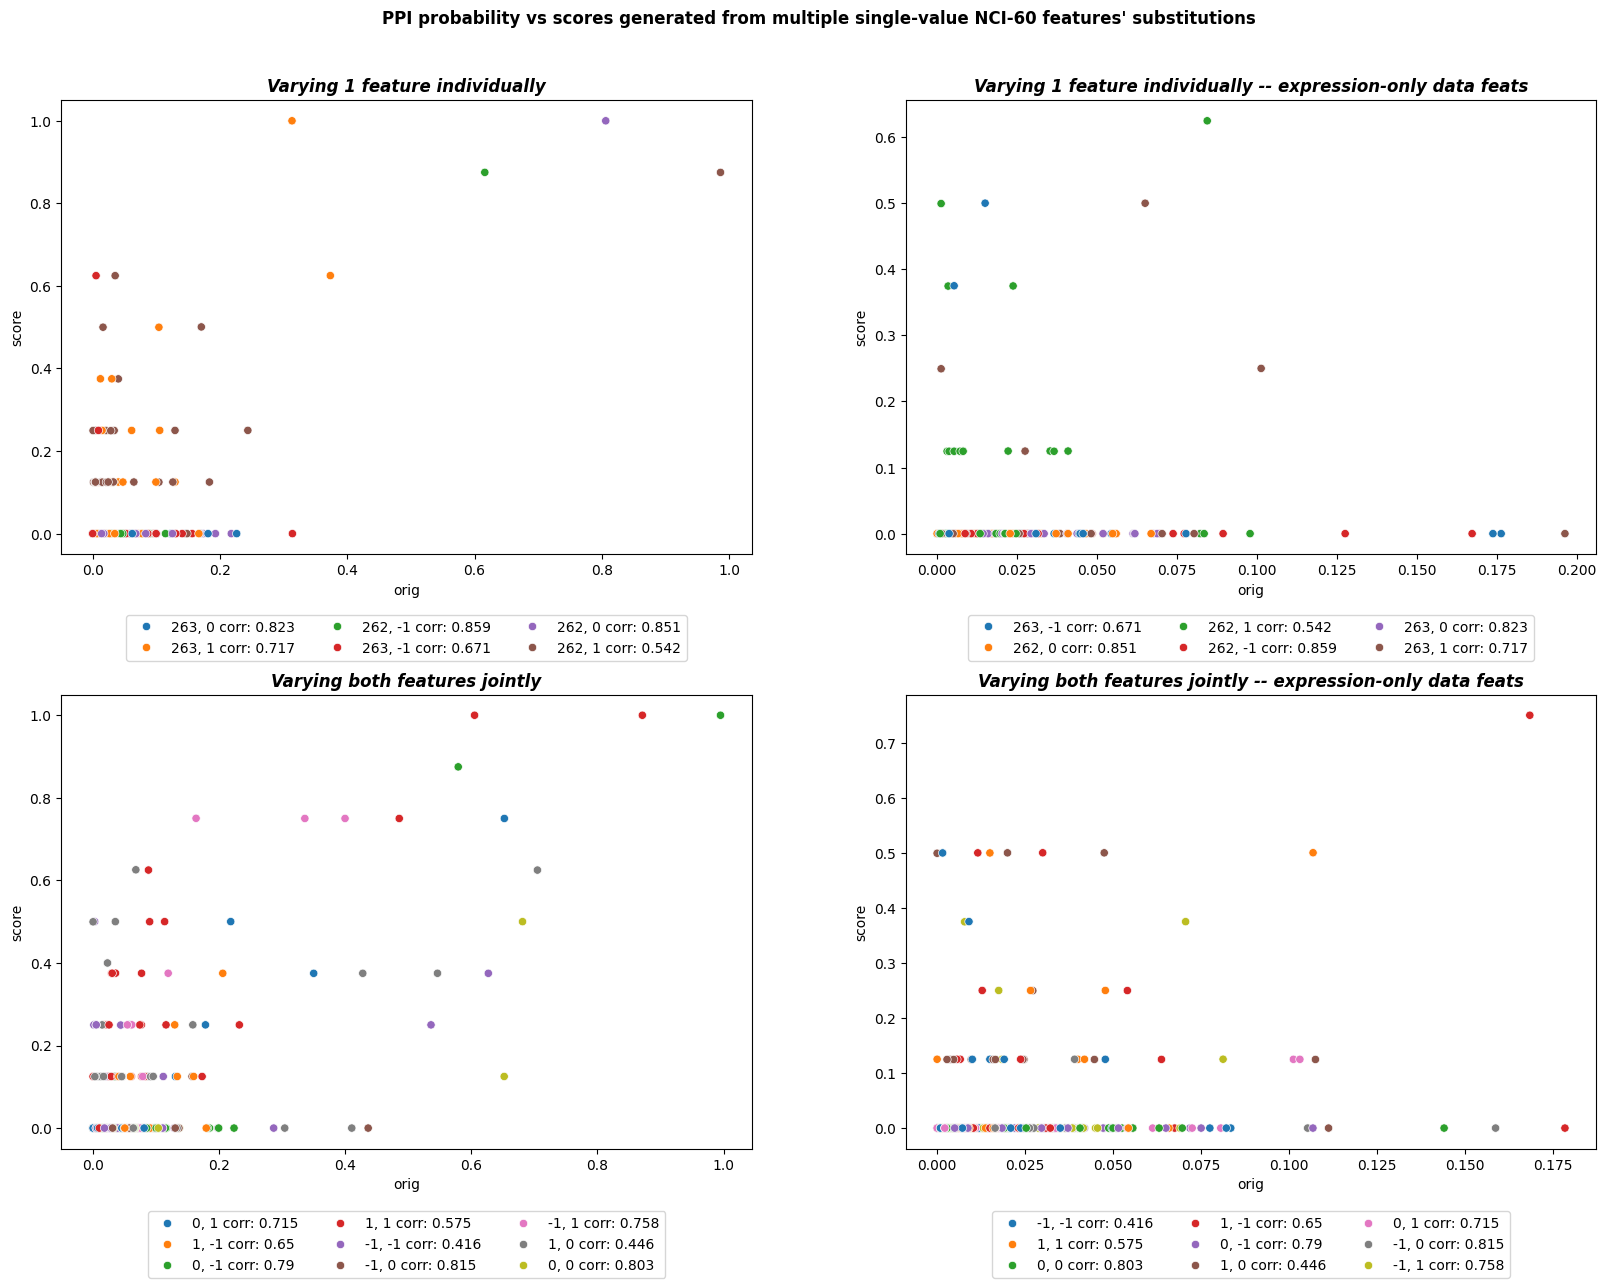

In [117]:
f, axs = plt.subplots(2, 2, figsize=(18, 13))
f.tight_layout(pad=8)
plt.suptitle('PPI probability vs scores generated from multiple ' +
             'single-value NCI-60 features\' substitutions',
             fontweight='bold')

sns.scatterplot(data=featVaried_single.loc[featVaried_single.pairsFrozen.isin(
    elcfsPairs_pairLevel_featAvail)].sample(frac=sampFrac),
                x='orig', y='score', hue='featVaried,subsVal', ax=axs[0, 0])
axs[0, 0].set_title('Varying 1 feature individually',
                    fontweight='bold', style='italic')
axs[0, 0].legend(bbox_to_anchor=(.5, -.25), loc='lower center', ncols=3)

sns.scatterplot(data=featVaried_single.loc[featVaried_single.pairsFrozen.isin(
    elcfsPairs_protLevel_featOnly)].sample(frac=sampFrac),
                x='orig', y='score', hue='featVaried,subsVal', ax=axs[0, 1])
axs[0, 1].set_title('Varying 1 feature individually' +
                    ' -- expression-only data feats',
                    fontweight='bold', style='italic')
axs[0, 1].legend(bbox_to_anchor=(.5, -.25), loc='lower center', ncols=3)

sns.scatterplot(data=featVaried_joint.loc[featVaried_joint.pairsFrozen.isin(
    elcfsPairs_pairLevel_featAvail)].sample(frac=sampFrac),
                x='orig', y='score', hue='featVaried,subsVal', ax=axs[1, 0])
axs[1, 0].set_title('Varying both features jointly',
                    fontweight='bold', style='italic')
axs[1, 0].legend(bbox_to_anchor=(.5, -.30), loc='lower center', ncols=3)

sns.scatterplot(data=featVaried_joint.loc[featVaried_joint.pairsFrozen.isin(
    elcfsPairs_protLevel_featOnly)].sample(frac=sampFrac),
                x='orig', y='score', hue='featVaried,subsVal', ax=axs[1, 1])
axs[1, 1].set_title('Varying both features jointly' +
                    ' -- expression-only data feats',
                    fontweight='bold', style='italic')
axs[1, 1].legend(bbox_to_anchor=(.5, -.30), loc='lower center', ncols=3)

##Summary statistics for PPI probability predictions, segregated by availability of non-expression data features

>   Pairs with non-expression data available have higher means and STDs

>   After substituting cell line-specific values for NCI-60 features, predictions remain higher for pairs with non-expression data available, but the differences in mean and STD decrease by 15% and 34%, respectively

>   Further differentiating into cell line-specifity shows very little difference in summary statistics when grouping by non-expression data availability

In [10]:
elcfsPreds_fullSet_filename = workDir_ph1 + 'modelPerformance/' + \
  'modelsPerformance_integratedPairs_KD+LM+FGK+SCBC_cellSpecific_nci60Feats' + \
  '_noSCBCnulls-5CV/resultsConcatenated/' + \
  'probsPos-weighted_wlabeledPairs_inclCellh322+mcf7+u251.pkl'
elcfsPreds_fullSet = pickle.load(open(elcfsPreds_fullSet_filename, 'rb'))

In [ ]:
humap1Dir = refDir + 'huMAP1/'
humap2Dir = refDir + 'huMAP2/'
bcb19Dir_LM = refDir + 'Lugo-Martinez2019/'
stringdbDir = refDir + 'STRING/'
geneidDir = refDir + 'ftp.ncbi.nih.gov-gene-DATA-GENE_INFO/'
cmpStudies = reference.cmpStudies_props(
    humap1Dir, humap2Dir, bcb19Dir_LM, stringdbDir, geneidDir)
cmpStudies.go()

bcb19Preds = cmpStudies.bcb19Pairs_feat.copy()
bcb19Preds_labeled = bcb19Preds.merge(
    elcfsPreds_fullSet[['pairsFrozen', 'label']], on='pairsFrozen')

In [191]:
elcfsPreds_fullSet_expl = \
  elcfsPreds_fullSet.loc[elcfsPreds_fullSet.pairsFrozen.isin(
      elcfsPairs_protLevel_featOnly)]
elcfsPreds_fullSet_avail = \
  elcfsPreds_fullSet.loc[elcfsPreds_fullSet.pairsFrozen.isin(
      elcfsPairs_pairLevel_featAvail)]

prExpl, rExpl, thExpl = \
  precision_recall_curve(elcfsPreds_fullSet_expl.label,
                         elcfsPreds_fullSet_expl.nonspecific)
prrAUC_expl = auc(rExpl, prExpl)

prAvail, rAvail, thAvail = \
  precision_recall_curve(elcfsPreds_fullSet_avail.label,
                         elcfsPreds_fullSet_avail.nonspecific)
prrAUC_avail = auc(rAvail, prAvail)

print('AUC (non-expression data available): {:.2f}'.format(prrAUC_avail))
print('AUC (expression-only data available): {:.2f}'.format(prrAUC_expl))

AUC (non-expression data available): 0.21
AUC (expression-only data available): 0.01


In [21]:
bcb19Preds_expl = \
  bcb19Preds_labeled.loc[bcb19Preds_labeled.pairsFrozen.isin(
      elcfsPairs_protLevel_featOnly)]
bcb19Preds__avail = \
  bcb19Preds_labeled.loc[bcb19Preds_labeled.pairsFrozen.isin(
      elcfsPairs_pairLevel_featAvail)]

prExpl, rExpl, thExpl = \
  precision_recall_curve(bcb19Preds_expl.label, bcb19Preds_expl.prob)
prrAUC_expl = auc(rExpl, prExpl)

prAvail, rAvail, thAvail = \
  precision_recall_curve(bcb19Preds__avail.label, bcb19Preds__avail.prob)
prrAUC_avail = auc(rAvail, prAvail)

print('AUC (non-expression data available): {:.2f}'.format(prrAUC_avail))
print('AUC (expression-only data available): {:.2f}'.format(prrAUC_expl))

AUC (non-expression data available): 0.17
AUC (expression-only data available): 0.01


In [159]:
#transform DF for simpler plotting operations,
##e.g., comparing changes to original, so make new columns:
##(1) representing what was varied (and to what value) and
##(1) corresponding to the score, so that the new scores can be grouped by kind
idCols = ['id1', 'id2', 'pairsFrozen', 'label', 'orig']
elcfsPreds_fullSet_allSpecs_probs = \
  pd.melt(elcfsPreds_fullSet.rename(columns={'nonspecific': 'orig'}),
          id_vars=idCols, var_name='specificity', value_name='prob')

In [160]:
#create column for separating predictions by whether non-expression data was available
elcfsPreds_fullSet_allSpecs_probs.insert(3, 'expressLimited', np.nan)
elcfsPreds_fullSet_allSpecs_probs.loc[
    elcfsPreds_fullSet_allSpecs_probs.pairsFrozen.isin(
        elcfsPairs_pairLevel_featAvail), 'expressLimited'] = False
elcfsPreds_fullSet_allSpecs_probs.loc[
    elcfsPreds_fullSet_allSpecs_probs.pairsFrozen.isin(
        elcfsPairs_protLevel_featOnly), 'expressLimited'] = True

In [173]:
##compare non-specific prediction stats with non-expression data availability
elcfsPreds_fullSet_allSpecs_probs.loc[
    elcfsPreds_fullSet_allSpecs_probs.expressLimited==False,
    'orig'].describe().loc[['mean', 'std', 'min', 'max']]

mean    0.033761
std     0.089155
min     0.000000
max     1.000000
Name: orig, dtype: float64

In [174]:
##compare non-specific prediction stats with only expression data availability
elcfsPreds_fullSet_allSpecs_probs.loc[
    elcfsPreds_fullSet_allSpecs_probs.expressLimited==True,
    'orig'].describe().loc[['mean', 'std', 'min', 'max']]

mean    0.017086
std     0.024974
min     0.000000
max     0.736451
Name: orig, dtype: float64

>   Pairs with non-expression data available have higher means and STDs

In [175]:
##compare cell line-specific prediction stats with non-expression data availability
elcfsPreds_fullSet_allSpecs_probs.loc[(
    (elcfsPreds_fullSet_allSpecs_probs.expressLimited==False) &
    (elcfsPreds_fullSet_allSpecs_probs.specificity.isin(
        ['h322', 'mcf7', 'u251']))), 'prob'].describe().loc[
            ['mean', 'std', 'min', 'max']]

mean    0.034194
std     0.098510
min     0.000000
max     1.000000
Name: prob, dtype: float64

In [176]:
##compare cell line-specific prediction stats with only expression data availability
elcfsPreds_fullSet_allSpecs_probs.loc[(
    (elcfsPreds_fullSet_allSpecs_probs.expressLimited==True) &
    (elcfsPreds_fullSet_allSpecs_probs.specificity.isin(
        ['h322', 'mcf7', 'u251']))), 'prob'].describe().loc[
            ['mean', 'std', 'min', 'max']]

mean    0.022084
std     0.060806
min     0.000000
max     1.000000
Name: prob, dtype: float64

>   After substituting cell line-specific values for NCI-60 features, predictions remain higher for pairs with non-expression data available, but the differences in mean and STD decrease by 15% and 34%, respectively.

In [183]:
##compare prediction stats by cell line with non-expression data availability
{cell: elcfsPreds_fullSet_allSpecs_probs.loc[(
    (elcfsPreds_fullSet_allSpecs_probs.expressLimited==False) &
    (elcfsPreds_fullSet_allSpecs_probs.specificity==cell)), 'prob'].describe().loc[
            ['mean', 'std', 'min', 'max']] for cell in ['h322', 'mcf7', 'u251']}

{'h322': mean    0.034120
 std     0.098387
 min     0.000000
 max     1.000000
 Name: prob, dtype: float64,
 'mcf7': mean    0.034281
 std     0.098624
 min     0.000000
 max     1.000000
 Name: prob, dtype: float64,
 'u251': mean    0.034180
 std     0.098518
 min     0.000000
 max     1.000000
 Name: prob, dtype: float64}

In [184]:
##compare prediction stats by cell line with only expression data availability
{cell: elcfsPreds_fullSet_allSpecs_probs.loc[(
    (elcfsPreds_fullSet_allSpecs_probs.expressLimited==True) &
    (elcfsPreds_fullSet_allSpecs_probs.specificity==cell)), 'prob'].describe().loc[
            ['mean', 'std', 'min', 'max']] for cell in ['h322', 'mcf7', 'u251']}

{'h322': mean    0.022054
 std     0.060697
 min     0.000000
 max     1.000000
 Name: prob, dtype: float64,
 'mcf7': mean    0.022153
 std     0.060855
 min     0.000000
 max     1.000000
 Name: prob, dtype: float64,
 'u251': mean    0.022046
 std     0.060867
 min     0.000000
 max     1.000000
 Name: prob, dtype: float64}

>   Further differentiating into cell line-specifity shows very little difference in summary statistics when grouping by non-expression data availability

<Axes: xlabel='orig', ylabel='prob'>

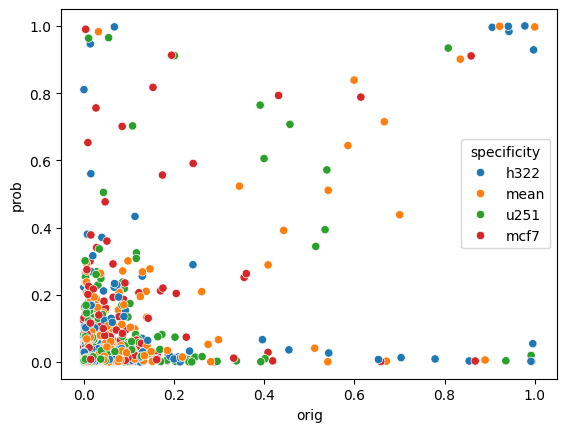

In [167]:
sampFrac2 = 0.001
sns.scatterplot(data=elcfsPreds_fullSet_allSpecs_probs.sample(frac=sampFrac2),
                x='orig', y='prob', hue='specificity')
#, size=None, style=None, markers=True, legend='auto')

#Archived experiments, statistics, (re Murphy: side-projects)

##Generate predictions by substituting each of the NCI-60 features with a single-valued arr using each of the following integers [-1, 0, 1]

In [ ]:
#Get indices for pairs with available feats conducive to select partition
def findPrtns_avail(inputs):
  arr, df = inputs
  featCols = list(np.argwhere(arr)[:, 0])
  dfBinary = df.notnull()
  rows = dfBinary.iloc[:, featCols].all(axis=1)
  rowsIdx = set(rows.loc[rows==True].index.tolist())
  return rowsIdx

In [ ]:
#Automate prediction generation using ELCFS modeling library
def predict(prtns, modelsProps, data, labels, dir, name, return_prr=False):

  candPrtns, candPrtns_preds, \
    candPrtns_predsProbs, modelsPerf_props = \
      modelEvaluating.evalPartitions(prtns, modelsProps, data, labels, dir, name)

  probsAcc, probsWeighted, labelsAdj = \
      modelEvaluating.evalTotal(candPrtns, candPrtns_preds, modelsPerf_props,
                                labels, dir, name)

  pAcc, rAcc, pWeighted, rWeighted = \
    modelEvaluating.evalSummary(probsAcc, probsWeighted, labelsAdj, dir, expName)

  predProbs_file = glob.glob(dir + 'model*/*Perf*/*weighted_results.csv')[0]
  predProbs = pd.read_csv(predProbs_file, names=['score'])

  if return_prr:
    return predProbs, pAcc, rAcc, pWeighted, rWeighted
  else:
    return predProbs

In [ ]:
#Generate maps from all models to the list of pairs w/ available corresponding feats
prtnsPair_dict = pickle.load(open(shortcutDir + 'prtnsPair_dict.pkl', 'rb'))
prtnsPairs = prtnsPair_dict['prtnsPairs']
prtnsPair_mapping = prtnsPair_dict['prtnsPair_mapping']

'''
print('Total partitions: {0} \nTotal features: {1}'.format(
    savedPartitions.shape[0], savedPartitions.shape[1]))
inputs = [(prtn, featMat) for prtn in savedPartitions]

numWorkers = cpu_count() - 1
print(numWorkers)
print('pooling...')
with Pool(numWorkers) as pool:
  prtnsPairs = \
    list(progressMonitor(pool.imap(findPrtns_avail, inputs), total=len(inputs)))
prtnsPair_mapping = dict(zip(prtnIDs, prtnsPairs))
'''

'''
pickle.dump(
    {'prtnsPairs': prtnsPairs, 'prtnsPair_mapping': prtnsPair_mapping},
    open(shortcutDir + 'prtnsPair_dict.pkl', 'wb'))
'''

"\npickle.dump(\n    {'prtnsPairs': prtnsPairs, 'prtnsPair_mapping': prtnsPair_mapping}, \n    open(shortcutDir + 'prtnsPair_dict.pkl', 'wb'))\n"

In [ ]:
#Identify pairs for which the partition-models are available
##generate power set of all pairs for which their available feats correspond to
##those of the missing partition-models
missingPrtns_pairs = \
  set().union(*[set(prtnsPair_mapping[p]) for p in missingPrtns])

##generate power set of all pairs for which their available feats correspond to
##those of all the partition-models present
availablePrtns_pairs = set(featMat.index.tolist()).difference(missingPrtns_pairs)

##Make copy of feature matrix with only pairs for which partitions are available
featMat_prtnsAvail = \
  featMat.loc[availablePrtns_pairs].reset_index(drop=True).copy()

##Make copy of predictions from original feature values w/ only pairs for which
##partitions are available
origPreds_prtnsAvail = \
  predProbs.loc[availablePrtns_pairs].reset_index(drop=True).copy()

##Make copy of labels corresponding to only pairs for which partitions are available
matLabels_prtnsAvail = labels.loc[availablePrtns_pairs].reset_index(drop=True).copy()
print('Pair total w/ missing partition-models: {0}'.format(
    len(missingPrtns_pairs)))
print('Pair total w/ available partition-models: {0}'.format(
    len(availablePrtns_pairs)))
print('Pair total w/ missing & available partition-models == ' +
      'pair total: {0}'.format(
          len(missingPrtns_pairs) + len(availablePrtns_pairs) == len(featMat)))
print('Dimensions of the feature matrix ' +
      'with only pairs for which partitions are available: {0}'.format(
          featMat_prtnsAvail.shape))
print('Dimensions of the predictions generated from the feature matrix ' +
      'with only pairs for which partitions are available: {0}'.format(
          origPreds_prtnsAvail.shape))
print('Dimensions of the labels corresponding to only pairs for which partitions are available: {0}'.format(
          matLabels_prtnsAvail.shape))

Pair total w/ missing partition-models: 2805
Pair total w/ available partition-models: 204777
Pair total w/ missing & available partition-models == pair total: True
Dimensions of the feature matrix with only pairs for which partitions are available: (204777, 276)
Dimensions of the predictions generated from the feature matrix with only pairs for which partitions are available: (204777, 1)
Dimensions of the labels corresponding to only pairs for which partitions are available: (204777, 1)


In [ ]:
#Make single-value substitutions for each NCI-60 feature, individually and generate predictions
##should have 6 sets of predictions
predProbs_featMat_indSubs = {}
for featCol in ['262', '263']:
  for var in [-1, 0, 1]:
    print('Substitution value: {0}'.format(var))

    featMat_substitution = featMat_prtnsAvail.copy()
    featMat_substitution.loc[:, featCol] = var
    predProbs_featMat_indSubs[', '.join([featCol, str(var)])] = \
      predict(savedPartitions, modelsProperties,
              featMat_substitution, matLabels_prtnsAvail, workDir_ph1, name)

In [ ]:
#Make single-value substitutions for both NCI-60 features and generate predictions
##should have 9 sets of predictions
predProbs_featMat_jointSubs = {}
singleVal_subsPairs = list(it.product([-1, 0, 1], [-1, 0, 1]))
for subsPair in singleVal_subsPairs:
  print('Substitution values: {0}'.format(subsPair))

  featMat_substitution = featMat_prtnsAvail.copy()
  featMat_substitution.loc[:, '262'] = subsPair[0]
  featMat_substitution.loc[:, '263'] = subsPair[1]
  predProbs_featMat_jointSubs[', '.join([str(j) for j in subsPair])] = \
    predict(savedPartitions, modelsProperties,
            featMat_substitution, matLabels_prtnsAvail, workDir_ph1, name)

In [ ]:
predProbs_nci60Subs_filename = shortcutDir + 'predProbs_nci60Feat_featMat_subsTesting.pkl'
predProbs_nci60Feat_featMat_subsTesting = \
  pickle.load(open(predProbs_nci60Subs_filename, 'rb'))

'''
pickle.dump(predProbs_nci60Feat_featMat_subsTesting, open(predProbs_nci60Subs_filename, 'wb'))
'''

##Summary statistics on partition-models for which NCI-60 RNA and protein correlation features are most influential based on the product of the partition-model's Pr-R AUC and the contribution strength for both RNA and protein.

In [ ]:
#Check training partition IDs are unique
modelsPerf['training partition ID'].nunique()

In [ ]:
#Check NCI-60 features (cols 262, 263) are present in all partitions
##since rna and protein co-expression available for all pairs
modelsPerf.loc[modelsPerf.features.str.contains('262', '263')].shape

In [ ]:
#sort partitions by num features
modelsPerf.sort_values(by=['num features']).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features
0,0,0.976115,0.035491,0.036730,0.975398,2.0,"['262', '263']"
112,112,0.974309,0.271645,0.273405,0.973843,3.0,"['253', '262', '263']"
191,191,0.973935,0.259562,0.261395,0.973676,3.0,"['252', '262', '263']"
31,31,0.972052,0.262347,0.263943,0.971120,3.0,"['260', '262', '263']"
15,15,0.973546,0.278518,0.280228,0.972086,3.0,"['261', '262', '263']"


In [ ]:
#sort partitions by Pr-R AUC
modelsPerf.sort_values(by=['Pr-R AUC'], ascending=True).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features
0,0,0.976115,0.035491,0.036730,0.975398,2.0,"['262', '263']"
1,1,0.975764,0.070284,0.071964,0.975057,6.0,"['262', '263', '267', '268', '269', '270']"
8,8,0.978926,0.082467,0.083323,0.978006,4.0,"['262', '263', '264', '266']"
5,5,0.978950,0.101134,0.102119,0.978276,4.0,"['262', '263', '265', '266']"
11,11,0.979245,0.108214,0.109218,0.978505,5.0,"['262', '263', '264', '265', '266']"


In [ ]:
#sort partitions by Pr-R AUC
modelsPerf.sort_values(by=['Pr-R AUC'], ascending=False).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features
695,695,0.833333,1.0,1.0,0.888889,27.0,"['241', '242', '243', '244', '245', '246', '24..."
708,708,1.000000,1.0,1.0,0.930233,28.0,"['241', '242', '243', '244', '245', '246', '24..."
706,706,1.000000,1.0,1.0,0.956522,24.0,"['241', '242', '243', '244', '245', '246', '24..."
700,700,1.000000,1.0,1.0,0.800000,28.0,"['241', '242', '243', '244', '245', '246', '24..."
710,710,1.000000,1.0,1.0,0.939394,22.0,"['241', '242', '243', '244', '245', '246', '24..."


Text(0.5, 1.0, 'Partitions with total features >= 100')

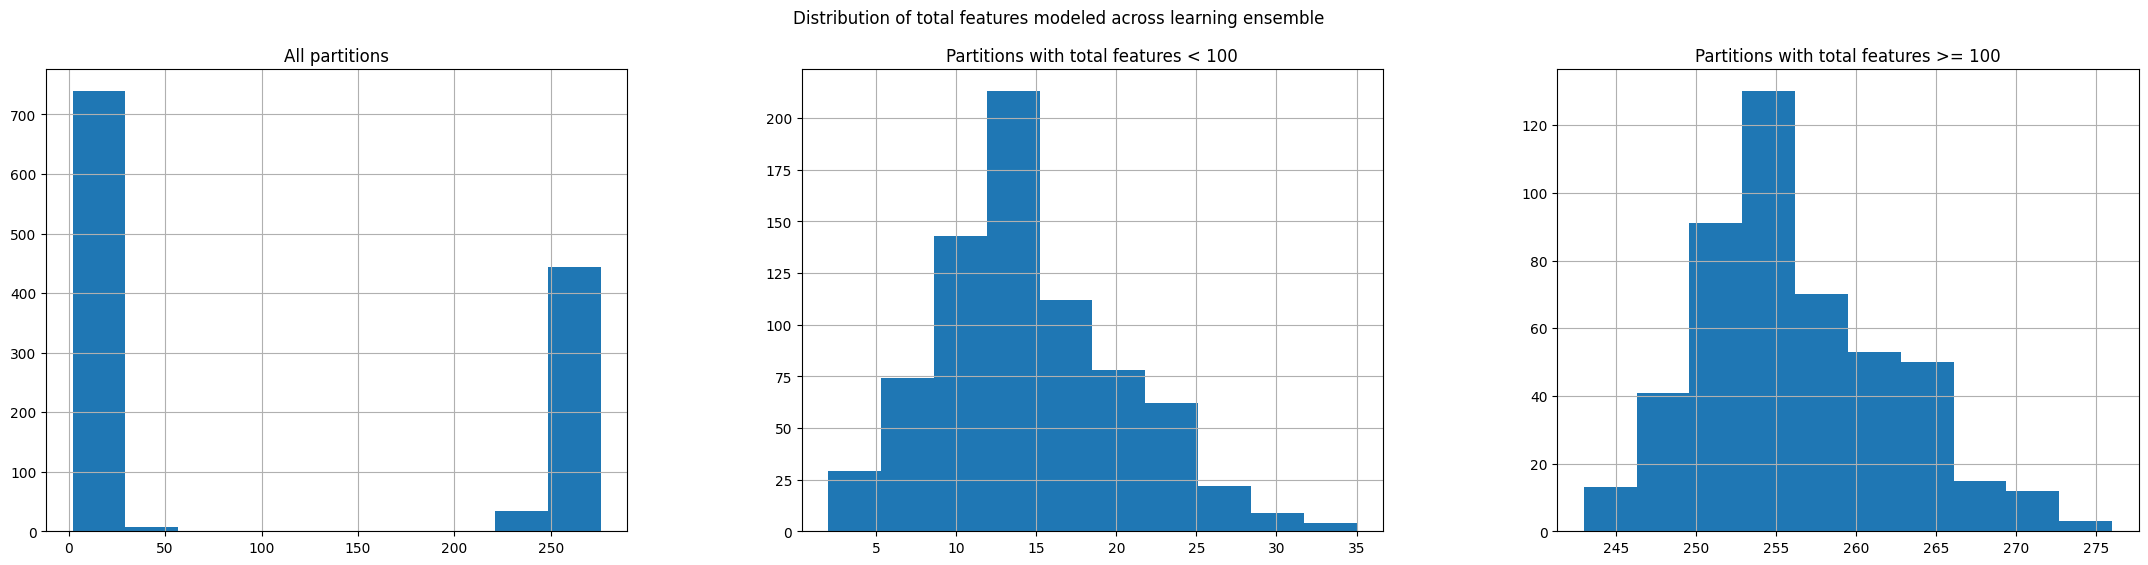

In [ ]:
#what is the distribution of 'num features?'
f, axs = plt.subplots(1, 3, figsize=(27, 6))
plt.suptitle('Distribution of total features modeled across learning ensemble')
modelsPerf.hist(column='num features', ax=axs[0])
axs[0].set_title('All partitions')
modelsPerf.loc[modelsPerf['num features'] < 100].hist(column='num features', ax=axs[1])
axs[1].set_title('Partitions with total features < 100')
modelsPerf.loc[modelsPerf['num features'] >= 100].hist(column='num features', ax=axs[2])
axs[2].set_title('Partitions with total features >= 100')

##Summary statistics on the aggregate strength of contribution for the NCI-60 RNA and protein correlation features.

In [ ]:
def getModels_featImportances(f):
  m = pickle.load(open(f, 'rb'))
  if len(m.classes_) > 1:
    return list(m.feature_importances_)
  else:
    return np.nan

In [ ]:
#load models into memory and extract feature importances

##computer was faster...
featWeight = pickle.load(open(workDir + 'featWeight.pkl', 'rb'))

'''
numWorkers = cpu_count() - 1
print(numWorkers)
print('pooling...')
with Pool(numWorkers) as pool:
  featWeight = \
    list(progressMonitor(pool.imap(
        getModels_featImportances, modelFiles),
                         total=len(modelFiles)))
'''

"\nnumWorkers = cpu_count() - 1\nprint(numWorkers)\nprint('pooling...')\nwith Pool(numWorkers) as pool:\n  featWeight =     list(progressMonitor(pool.imap(\n        getModels_featImportances, modelFiles), \n                         total=len(modelFiles)))\n"

In [ ]:
featWeight_mapped = pd.DataFrame({'prtn': prtnNums, 'featWeight': featWeight})
featWeight_mapped.drop_duplicates(subset=['prtn'], inplace=True)
print(featWeight_mapped.isna().sum())
print(featWeight_mapped.notnull().sum())
featWeight_mapped.head()

prtn           0
featWeight    26
dtype: int64
prtn          1189
featWeight    1163
dtype: int64


,prtn,featWeight
0,0,"[0.5021255339477284, 0.4978744660522716]"
1,1000,"[0.004087942891747578, 0.0008522162735617768, ..."
2,1001,"[0.0043700789307923, 0.0010310760157964441, 4...."
3,1002,"[0.005086641458109487, 0.0010404363086602207, ..."
4,1003,"[5.4139095664551155e-05, 0.004456332866001557,..."


In [ ]:
#find the features' contribution strength for each partition model
modelsPerf['mappings'] = np.nan
for prtn in featWeight_mapped.loc[featWeight_mapped.featWeight.notnull()].prtn:
  modelsPerf.loc[modelsPerf['training partition ID']==prtn, 'mappings'] = \
    [dict(zip(
        [n
         for n in modelsPerf.loc[
             modelsPerf['training partition ID']==prtn].features.values[0].split(
                 '\'') if n.isnumeric()], featWeight_mapped.loc[
                     featWeight_mapped.prtn==prtn].featWeight.values[0]))]

In [ ]:
#confirm that the mappings from the partition-models to their
#respective features' contribution strength is consistent with each
#partition-model's feature total
modelsPerf['mappingKeys'] = \
  [len(modelsPerf.loc[i, 'mappings'].keys())
    if isinstance(modelsPerf.loc[i, 'mappings'], dict) else np.nan
    for i in modelsPerf.index]
all(
    [modelsPerf.loc[ix, 'num features'] == modelsPerf.loc[ix, 'mappingKeys']
     for ix in modelsPerf.loc[modelsPerf.mappingKeys.notnull()].index]
)

True

In [ ]:
#need to figure out what's weird about these partitions
##too few test data?
##only 1 class label available?
modelsPerf.loc[(modelsPerf['training partition ID'].isin(prtnNums)) &
               (modelsPerf['mappingKeys'].isna())].head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features
656,656,0.5,0.5,0.75,1.0,34.0,"['241', '242', '243', '244', '245', '246', '24..."
681,681,1.0,NaN,NaN,1.0,32.0,"['241', '242', '243', '244', '245', '246', '24..."
743,743,1.0,NaN,NaN,1.0,34.0,"['241', '242', '243', '244', '245', '246', '24..."
745,745,1.0,NaN,NaN,1.0,35.0,"['241', '242', '243', '244', '245', '246', '24..."
1005,1005,0.6,0.6,0.80,1.0,264.0,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ..."


In [ ]:
modelsPerf.loc[(modelsPerf['training partition ID'].isin(prtnNums)) &
               (modelsPerf['mappingKeys'].notnull())].shape

(1163, 14)

In [ ]:
modelsPerf['262Weight'] = np.nan
modelsPerf['263Weight'] = np.nan
for ix in modelsPerf.loc[
    (modelsPerf['training partition ID'].isin(prtnNums)) &
     (modelsPerf['mappingKeys'].notnull())].index:

     modelsPerf.loc[ix, '262Weight'] = modelsPerf.loc[ix, 'mappings']['262']
     modelsPerf.loc[ix, '263Weight'] = modelsPerf.loc[ix, 'mappings']['263']

In [ ]:
modelsPerf['262Weight_featStrength_prrauc'] = \
  modelsPerf['262Weight'] * modelsPerf['Pr-R AUC']
modelsPerf['263Weight_featStrength_prrauc'] = \
  modelsPerf['263Weight'] * modelsPerf['Pr-R AUC']

In [ ]:
modelsPerf_avail = \
  modelsPerf.loc[
      (modelsPerf['training partition ID'].isin(prtnNums)) &
       (modelsPerf['mappingKeys'].notnull())].copy()
modelsPerf_avail.drop(
    columns=['filePresent',
             'num test-data observations', 'num train-data observations',
             'mappings', 'mappingKeys'], inplace=True)
modelsPerf_avail.reset_index(drop=True, inplace=True)

In [ ]:
modelsPerf_avail[['262Weight_featStrength_prrauc', '263Weight_featStrength_prrauc']].min()

262Weight_featStrength_prrauc    0.0
263Weight_featStrength_prrauc    0.0
dtype: float64

In [ ]:
modelsPerf_avail[['262Weight_featStrength_prrauc', '263Weight_featStrength_prrauc']].max()

262Weight_featStrength_prrauc    0.168339
263Weight_featStrength_prrauc    0.184508
dtype: float64

In [ ]:
modelsPerf_avail[['262Weight_featStrength_prrauc', '263Weight_featStrength_prrauc']].mean()

262Weight_featStrength_prrauc    0.032355
263Weight_featStrength_prrauc    0.037287
dtype: float64

In [ ]:
modelsPerf_avail[['262Weight_featStrength_prrauc', '263Weight_featStrength_prrauc']].median()

262Weight_featStrength_prrauc    0.024867
263Weight_featStrength_prrauc    0.032063
dtype: float64

In [ ]:
modelsPerf_avail.sort_values(by=['262Weight_featStrength_prrauc'], ascending=False).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features,262Weight,263Weight,262Weight_featStrength_prrauc,263Weight_featStrength_prrauc
390,390,0.867234,0.623630,0.624760,0.864742,4.0,"['250', '251', '262', '263']",0.269446,0.268190,0.168339,0.167554
57,57,0.883626,0.735340,0.736352,0.883528,8.0,"['258', '259', '262', '263', '267', '268', '26...",0.226649,0.248293,0.166893,0.182831
391,391,0.888270,0.722581,0.724023,0.888916,8.0,"['250', '251', '262', '263', '267', '268', '26...",0.212697,0.214314,0.153997,0.155168
2,2,0.978895,0.785238,0.787299,0.974362,11.0,"['262', '263', '267', '268', '269', '270', '27...",0.192734,0.234356,0.151739,0.184508
63,63,0.895659,0.758844,0.759733,0.889472,5.0,"['258', '259', '261', '262', '263']",0.177337,0.208723,0.134729,0.158574


In [ ]:
modelsPerf_avail.sort_values(by=['262Weight_featStrength_prrauc'], ascending=True).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features,262Weight,263Weight,262Weight_featStrength_prrauc,263Weight_featStrength_prrauc
473,473,0.428571,0.684524,0.642262,1.000000,25.0,"['250', '251', '253', '254', '255', '256', '25...",0.0,0.000000,0.0,0.000000
469,469,0.750000,0.932884,0.929097,1.000000,22.0,"['250', '251', '253', '254', '255', '256', '25...",0.0,0.000000,0.0,0.000000
618,618,0.666667,0.966667,0.963333,0.945946,23.0,"['250', '251', '252', '253', '254', '255', '25...",0.0,0.000000,0.0,0.000000
810,814,0.777778,0.926667,0.918333,0.884615,263.0,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...",0.0,0.007927,0.0,0.007280
923,927,0.666667,0.958333,0.955357,0.951220,261.0,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...",0.0,0.001295,0.0,0.001237


In [ ]:
modelsPerf_avail.sort_values(by=['263Weight_featStrength_prrauc'], ascending=False).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features,262Weight,263Weight,262Weight_featStrength_prrauc,263Weight_featStrength_prrauc
2,2,0.978895,0.785238,0.787299,0.974362,11.0,"['262', '263', '267', '268', '269', '270', '27...",0.192734,0.234356,0.151739,0.184508
57,57,0.883626,0.735340,0.736352,0.883528,8.0,"['258', '259', '262', '263', '267', '268', '26...",0.226649,0.248293,0.166893,0.182831
390,390,0.867234,0.623630,0.624760,0.864742,4.0,"['250', '251', '262', '263']",0.269446,0.268190,0.168339,0.167554
192,192,0.973027,0.841492,0.844526,0.968954,8.0,"['252', '262', '263', '271', '272', '273', '27...",0.136158,0.191523,0.114989,0.161746
63,63,0.895659,0.758844,0.759733,0.889472,5.0,"['258', '259', '261', '262', '263']",0.177337,0.208723,0.134729,0.158574


In [ ]:
modelsPerf_avail.sort_values(by=['263Weight_featStrength_prrauc'], ascending=True).head()

,training partition ID,testing accuracy,average precision,Pr-R AUC,est model accuracy,num features,features,262Weight,263Weight,262Weight_featStrength_prrauc,263Weight_featStrength_prrauc
469,469,0.750000,0.932884,0.929097,1.00,22.0,"['250', '251', '253', '254', '255', '256', '25...",0.000000,0.0,0.000000,0.0
473,473,0.428571,0.684524,0.642262,1.00,25.0,"['250', '251', '253', '254', '255', '256', '25...",0.000000,0.0,0.000000,0.0
467,467,0.428571,0.709524,0.667262,1.00,24.0,"['250', '251', '253', '254', '255', '256', '25...",0.000000,0.0,0.000000,0.0
925,929,0.750000,1.000000,1.000000,0.75,264.0,"['0', '1', '2', '3', '4', '5', '6', '7', '8', ...",0.002519,0.0,0.002519,0.0
464,464,0.625000,0.709524,0.667262,1.00,23.0,"['250', '251', '253', '254', '255', '256', '25...",0.000000,0.0,0.000000,0.0


##Generate predictions using the partition-models most sensitive to changes in the NCI-60 features

In [ ]:
#most significantly impacted model from contribution of feature 262
feat262_topInfluence_modelPrtn = \
  modelsPerf_avail.sort_values(by=['262Weight_featStrength_prrauc'],
                               ascending=False).iloc[0]
print(feat262_topInfluence_modelPrtn)

#load corresponding model
feat262_topInfluence_modelFile = \
  glob.glob(modelsDir + '*model*Partition_{0}*.pkl'.format(
      feat262_topInfluence_modelPrtn['training partition ID']))[0]
feat262_topInfluence_model = \
  pickle.load(open(feat262_topInfluence_modelFile, 'rb'))

training partition ID                                     390
testing accuracy                                     0.867234
average precision                                     0.62363
Pr-R AUC                                              0.62476
est model accuracy                                   0.864742
num features                                              4.0
features                         ['250', '251', '262', '263']
262Weight                                            0.269446
263Weight                                             0.26819
262Weight_featStrength_prrauc                        0.168339
263Weight_featStrength_prrauc                        0.167554
Name: 390, dtype: object


In [ ]:
#most significantly impacted model from contribution of feature 263
feat263_topInfluence_modelPrtn = \
  modelsPerf_avail.sort_values(by=['263Weight_featStrength_prrauc'],
                               ascending=False).iloc[0]
print(feat263_topInfluence_modelPrtn)

#load corresponding model
feat263_topInfluence_modelFile = \
  glob.glob(modelsDir + '*model*Partition_{0}*.pkl'.format(
      feat263_topInfluence_modelPrtn['training partition ID']))[0]
feat263_topInfluence_model = \
  pickle.load(open(feat263_topInfluence_modelFile, 'rb'))

training partition ID                                                            2
testing accuracy                                                          0.978895
average precision                                                         0.785238
Pr-R AUC                                                                  0.787299
est model accuracy                                                        0.974362
num features                                                                  11.0
features                         ['262', '263', '267', '268', '269', '270', '27...
262Weight                                                                 0.192734
263Weight                                                                 0.234356
262Weight_featStrength_prrauc                                             0.151739
263Weight_featStrength_prrauc                                             0.184508
Name: 2, dtype: object


In [ ]:
#sanity check, confirm #feats == #allocated feat columns
print(sum(savedPartitions[
    feat262_topInfluence_modelPrtn['training partition ID']]))
print(sum(savedPartitions[
    feat263_topInfluence_modelPrtn['training partition ID']]))

4
11


In [ ]:
#set up mask for both partition arrs
feat262_topInfluence_modelPrtn_selFeat = \
  list(np.argwhere(savedPartitions[
      feat262_topInfluence_modelPrtn['training partition ID'], :])[:, 0])
feat263_topInfluence_modelPrtn_selFeat = \
  list(np.argwhere(savedPartitions[
      feat263_topInfluence_modelPrtn['training partition ID'], :])[:, 0])

In [ ]:
#following code only significant when arg specifying features subset
features = featMat.columns.tolist()
feat262_topInfluence_modelPrtn_selFeat = \
  [i for i in feat262_topInfluence_modelPrtn_selFeat if i < len(features)]
feat263_topInfluence_modelPrtn_selFeat = \
  [i for i in feat263_topInfluence_modelPrtn_selFeat if i < len(features)]

In [ ]:
#grab names (just using integers so nominal)
feat262_topInfluence_modelPrtn_selFeat_names = \
  [features[i] for i in feat262_topInfluence_modelPrtn_selFeat]
feat263_topInfluence_modelPrtn_selFeat_names = \
  [features[i] for i in feat263_topInfluence_modelPrtn_selFeat]

In [ ]:
#mask rows for which feat cols are uniformly present
feat262_topInfluence_modelPrtn_allRows_selectFeatures = \
  featMat_notnull.iloc[:, feat262_topInfluence_modelPrtn_selFeat].all(axis=1)
feat263_topInfluence_modelPrtn_allRows_selectFeatures = \
  featMat_notnull.iloc[:, feat263_topInfluence_modelPrtn_selFeat].all(axis=1)

In [ ]:
#grab row indices for which feat cols are uniformly present using gen'd mask
feat262_topInfluence_modelPrtn_rowIdx = \
  feat262_topInfluence_modelPrtn_allRows_selectFeatures.index[
      feat262_topInfluence_modelPrtn_allRows_selectFeatures].tolist()
feat263_topInfluence_modelPrtn_rowIdx = \
  feat263_topInfluence_modelPrtn_allRows_selectFeatures.index[
      feat263_topInfluence_modelPrtn_allRows_selectFeatures].tolist()

In [ ]:
#generate featmat subset for modeling according to ELCFS
feat262_topInfluence_modelPrtn_featMat_subs = \
  featMat.iloc[feat262_topInfluence_modelPrtn_rowIdx,
               feat262_topInfluence_modelPrtn_selFeat]
feat263_topInfluence_modelPrtn_featMat_subs = \
  featMat.iloc[feat263_topInfluence_modelPrtn_rowIdx,
               feat263_topInfluence_modelPrtn_selFeat]

In [ ]:
#sanity check: make sure the range for 262, 263 are indeed between (-1, 1)
feat262_topInfluence_modelPrtn_featMat_subs.min()

250    0.000000
251    1.000000
262   -0.618106
263   -0.995893
dtype: float64

In [ ]:
feat262_topInfluence_modelPrtn_featMat_subs.max()

250    146.152800
251     34.000000
262      0.798526
263      1.000000
dtype: float64

In [ ]:
feat263_topInfluence_modelPrtn_featMat_subs.min()

262   -0.671710
263   -0.949130
267    0.000000
268    0.000000
269    0.000000
270    0.000000
271    0.000000
272    0.000000
273    0.000000
274    0.000000
275    0.000992
dtype: float64

In [ ]:
feat262_topInfluence_modelPrtn_featMat_subs.max()

250    146.152800
251     34.000000
262      0.798526
263      1.000000
dtype: float64

In [ ]:
#generate pair interacting confidence estimates
feat262_topInfluence_modelPrtn_predsProbs = \
  feat262_topInfluence_model.predict_proba(
      feat262_topInfluence_modelPrtn_featMat_subs)[:, 1]
feat263_topInfluence_modelPrtn_predsProbs = \
  feat263_topInfluence_model.predict_proba(
      feat263_topInfluence_modelPrtn_featMat_subs)[:, 1]

[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished


In [ ]:
#[-1, 0, 1]
dummyFeat_262col = {}
dummyFeat_263col = {}
for k in [-1, 0, 1]:
  dummyFeat_262col[k] = \
    np.array([k for i in range(len(feat262_topInfluence_modelPrtn_featMat_subs))])
  dummyFeat_263col[k] = \
    np.array([k for i in range(len(feat263_topInfluence_modelPrtn_featMat_subs))])
  print(dummyFeat_262col[k].shape)
  print(dummyFeat_263col[k].shape)

dummyFeat_262col = pd.DataFrame(dummyFeat_262col)
dummyFeat_263col = pd.DataFrame(dummyFeat_263col)

(11637,)
(5591,)
(11637,)
(5591,)
(11637,)
(5591,)


In [ ]:
#j cols to evaluate and over which changes may be discovered:
## 1) orig featmat ## dummy vals

feat262_dummyVals = {}
feat263_dummyVals = {}
feat262_dummyVals['orig'] = feat262_topInfluence_modelPrtn_predsProbs
feat263_dummyVals['orig'] = feat263_topInfluence_modelPrtn_predsProbs
print(len(feat262_topInfluence_modelPrtn_predsProbs))
print(len(feat263_topInfluence_modelPrtn_predsProbs))

11637
5591


In [ ]:
#replace feat vals with dummy vals
for var in [-1, 0, 1]:
  print(var)

  featMat_262var = feat262_topInfluence_modelPrtn_featMat_subs.copy()
  featMat_262var.reset_index(drop=True, inplace=True)
  featMat_263var = feat263_topInfluence_modelPrtn_featMat_subs.copy()
  featMat_263var.reset_index(drop=True, inplace=True)

  featMat_262var.loc[:, '262'] = dummyFeat_262col[var].copy()
  featMat_263var.loc[:, '263'] = dummyFeat_263col[var].copy()

  feat262_dummyVals[var] = \
    feat262_topInfluence_model.predict_proba(featMat_262var)[:, 1]
  feat263_dummyVals[var] = \
    feat263_topInfluence_model.predict_proba(featMat_263var)[:, 1]

-1


[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s


0


[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s


1


[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished


In [ ]:
feat262_dummyVals = pd.DataFrame(feat262_dummyVals)
feat263_dummyVals = pd.DataFrame(feat263_dummyVals)

In [ ]:
feat262_dummyVals.mean()

orig    0.184455
-1      0.160551
0       0.153273
1       0.358418
dtype: float64

In [ ]:
feat262_dummyVals.std()

orig    0.247015
-1      0.242069
0       0.228293
1       0.288083
dtype: float64

In [ ]:
feat263_dummyVals.mean()

orig    0.441362
-1      0.329112
0       0.343770
1       0.652269
dtype: float64

In [ ]:
feat263_dummyVals.std()

orig    0.202221
-1      0.142898
0       0.194832
1       0.176379
dtype: float64

In [ ]:
#Murphy: investigate effect from changing feature values at key boundary points (-1, 0, 1) on probability estimates

##problem: not as clear to distinguish or recognize since some values are are already close to -1, 0, and 1
##alternative?: for each pair, change feat value as much as possible

##using the unit circle, rotations can be selected to find most distant points
def mapPoints_distinct(x, output=False):
  piRatio = math.acos(x)
  piRatio_90deg = (math.degrees(piRatio) + 90)*(math.pi/180) #+/- (both)
  piRatio_180deg = (math.degrees(piRatio) + 180)*(math.pi/180)

  if output:
    print(math.degrees(piRatio))
    print(math.degrees(piRatio_90deg))
    print(math.degrees(piRatio_180deg))
    print(x)
    print(math.cos(piRatio_90deg))
    print(math.cos(piRatio_180deg))

  newVals = \
    [math.cos(piRatio_180deg),
     math.cos(piRatio_90deg),
     -1*math.cos(piRatio_90deg)]

  return newVals

In [ ]:
#j cols to evaluate and over which changes may be discovered:
## 1) orig featmat,
 ##(6) featmats {3 most diff cols for primary feat interest &
 ##3 with secondary feat interest most diff}

feat262_probasVaried = {}
feat263_probasVaried = {}
feat262_probasVaried['orig'] = feat262_topInfluence_modelPrtn_predsProbs
feat263_probasVaried['orig'] = feat263_topInfluence_modelPrtn_predsProbs
print(len(feat262_topInfluence_modelPrtn_predsProbs))
print(len(feat263_topInfluence_modelPrtn_predsProbs))

11637
5591


In [ ]:
#prime feature varied separate
feat262_varySep = \
  pd.DataFrame(
      feat262_topInfluence_modelPrtn_featMat_subs['262'].apply(
          mapPoints_distinct, output=False).tolist(),
      columns=['180deg', '90deg', '-90deg'], )
feat263_varySep = \
  pd.DataFrame(
      feat263_topInfluence_modelPrtn_featMat_subs['263'].apply(
          mapPoints_distinct, output=False).tolist(),
      columns=['180deg', '90deg', '-90deg'])

In [ ]:
#vars: feature varied separately; varj: feature varied jointly
for var in ['180deg', '90deg', '-90deg']:
  print(var)

  featMat_262var = feat262_topInfluence_modelPrtn_featMat_subs.copy()
  featMat_262var.reset_index(drop=True, inplace=True)
  featMat_263var = feat263_topInfluence_modelPrtn_featMat_subs.copy()
  featMat_263var.reset_index(drop=True, inplace=True)

  featMat_262var.loc[:, '262'] = feat262_varySep[var].copy()
  featMat_263var.loc[:, '263'] = feat263_varySep[var].copy()

  feat262_probasVaried['vars ' + var] = \
    feat262_topInfluence_model.predict_proba(featMat_262var)[:, 1]
  feat263_probasVaried['vars ' + var] = \
    feat263_topInfluence_model.predict_proba(featMat_263var)[:, 1]

180deg


[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.


90deg


[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.


-90deg


[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.4s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.5s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished


In [ ]:
#prime feature varied jointly
feat262_joint263 = \
  pd.DataFrame(
      feat262_topInfluence_modelPrtn_featMat_subs['263'].apply(
          mapPoints_distinct, output=False).tolist(),
      columns=['180deg', '90deg', '-90deg'])
feat263_joint262 = \
  pd.DataFrame(
      feat263_topInfluence_modelPrtn_featMat_subs['262'].apply(
          mapPoints_distinct, output=False).tolist(),
      columns=['180deg', '90deg', '-90deg'])

In [ ]:
#vars: feature varied separately; varj: feature varied jointly
for var in ['180deg', '90deg', '-90deg']:
  print(var)

  featMat_262var = feat262_topInfluence_modelPrtn_featMat_subs.copy()
  featMat_262var.reset_index(drop=True, inplace=True)
  featMat_263var = feat263_topInfluence_modelPrtn_featMat_subs.copy()
  featMat_263var.reset_index(drop=True, inplace=True)

  featMat_262var.loc[:, '262'] = feat262_varySep[var].copy()
  featMat_262var.loc[:, '263'] = feat262_joint263[var].copy()
  featMat_263var.loc[:, '263'] = feat263_varySep[var].copy()
  featMat_263var.loc[:, '262'] = feat263_joint262[var].copy()

  feat262_probasVaried['varj ' + var] = \
    feat262_topInfluence_model.predict_proba(featMat_262var)[:, 1]
  feat263_probasVaried['varj ' + var] = \
    feat263_topInfluence_model.predict_proba(featMat_263var)[:, 1]

180deg


[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.2s


90deg


[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished


-90deg


[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=96)]: Using backend ThreadingBackend with 96 concurrent workers.
[Parallel(n_jobs=96)]: Done 173 tasks      | elapsed:    0.1s
[Parallel(n_jobs=96)]: Done 400 out of 400 | elapsed:    0.2s finished


In [ ]:
feat262_topInfluence_modelPrtn_pairs = \
  pairs.iloc[feat262_topInfluence_modelPrtn_rowIdx]
feat262_topInfluence_modelPrtn_pairs.reset_index(drop=True, inplace=True)
feat263_topInfluence_modelPrtn_pairs = \
  pairs.iloc[feat263_topInfluence_modelPrtn_rowIdx]
feat263_topInfluence_modelPrtn_pairs.reset_index(drop=True, inplace=True)

In [ ]:
feat262_probasVaried = \
  pd.concat([feat262_topInfluence_modelPrtn_pairs,
             pd.DataFrame(feat262_probasVaried)], axis=1)
feat263_probasVaried = \
  pd.concat([feat263_topInfluence_modelPrtn_pairs,
             pd.DataFrame(feat263_probasVaried)], axis=1)

In [ ]:
varySep_cols = ['vars 180deg', 'vars 90deg', 'vars -90deg']
varyJoint_cols = ['varj 180deg', 'varj 90deg', 'varj -90deg']
varyAll_cols = \
  ['orig',
   'vars 180deg', 'vars 90deg', 'vars -90deg',
   'varj 180deg', 'varj 90deg', 'varj -90deg']

###3262 (NCI-60 RNA feature)
>   min, max: 0, 1 respectively

In [ ]:
feat262_probasVaried.orig.mean()

0.18445454154850907

In [ ]:
feat262_probasVaried.orig.std()

0.24701477291141885

In [ ]:
feat262_probasVaried[varySep_cols].mean().mean()

0.22442439345764945

In [ ]:
feat262_probasVaried[varySep_cols].std()

vars 180deg    0.233769
vars 90deg     0.242069
vars -90deg    0.288072
dtype: float64

In [ ]:
feat262_probasVaried[varyJoint_cols].mean().mean()

0.25328528257569244

In [ ]:
feat262_probasVaried[varyJoint_cols].std()

varj 180deg    0.208091
varj 90deg     0.232575
varj -90deg    0.189755
dtype: float64

In [ ]:
feat262_probasVaried[varyAll_cols].mean().mean()

0.23108336709264785

In [ ]:
feat262_probasVaried[varyAll_cols].std()

orig           0.247015
vars 180deg    0.233769
vars 90deg     0.242069
vars -90deg    0.288072
varj 180deg    0.208091
varj 90deg     0.232575
varj -90deg    0.189755
dtype: float64

###263 (NCI-60 Prot feature)
>   min, max: ~0.02, 1.0

In [ ]:
feat263_probasVaried.orig.mean()

0.44136245752101594

In [ ]:
feat263_probasVaried.orig.std()

0.20222109825971568

In [ ]:
feat263_probasVaried[varySep_cols].mean().mean()

0.4658790913968878

In [ ]:
feat263_probasVaried[varySep_cols].std()

vars 180deg    0.177745
vars 90deg     0.142963
vars -90deg    0.174091
dtype: float64

In [ ]:
feat263_probasVaried[varyJoint_cols].mean().mean()

0.5677571096404938

In [ ]:
feat263_probasVaried[varyJoint_cols].std()

varj 180deg    0.173772
varj 90deg     0.089138
varj -90deg    0.023495
dtype: float64

In [ ]:
feat263_probasVaried[varyAll_cols].mean().mean()

0.5060387229475943

##Estimate maximally possible difference and compare to differences between the original feature values and the cell line-specific ratios of NCI-60 RNA/prot expression

In [ ]:
feat262_probasVaried['maxDiff'] = \
  [max(
      [abs(feat262_probasVaried.loc[ix, 'orig'] - x)/feat262_probasVaried.loc[ix, 'orig']
        for x in feat262_probasVaried.loc[ix, varyAll_cols[1:]].to_list()])
  for ix in feat262_probasVaried.index]

feat263_probasVaried['maxDiff'] = \
  [max(
      [abs(feat263_probasVaried.loc[ix, 'orig'] - x)/feat262_probasVaried.loc[ix, 'orig']
        for x in feat263_probasVaried.loc[ix, varyAll_cols[1:]].to_list()])
  for ix in feat263_probasVaried.index]

In [ ]:
elcfsProbs = pickle.load(open(shortcutDir + 'elcfsProbs_cellSpecific.pkl', 'rb'))

In [ ]:
cellLine_cols = ['probsPos_h322', 'probsPos_mcf7', 'probsPos_u251']

In [ ]:
feat262_elcfsProbs = \
  elcfsProbs.loc[elcfsProbs.pairsFrozen.isin(
      feat262_probasVaried.pairsFrozen.to_list())]

In [ ]:
feat263_elcfsProbs = \
  elcfsProbs.loc[elcfsProbs.pairsFrozen.isin(
      feat263_probasVaried.pairsFrozen.to_list())]

In [ ]:
feat262_elcfsProbs['maxDiff'] = \
  [max(
      [abs(feat262_elcfsProbs.loc[ix, 'nonspecific'] - x)/feat262_elcfsProbs.loc[ix, 'nonspecific']
        for x in feat262_elcfsProbs.loc[ix, cellLine_cols].to_list()])
  for ix in feat262_elcfsProbs.index]

feat263_elcfsProbs['maxDiff'] = \
  [max(
      [abs(feat263_elcfsProbs.loc[ix, 'nonspecific'] - x)/feat263_elcfsProbs.loc[ix, 'nonspecific']
        for x in feat263_elcfsProbs.loc[ix, cellLine_cols].to_list()])
  for ix in feat263_elcfsProbs.index]

In [ ]:
print(feat262_probasVaried.maxDiff.min(numeric_only=True))
print(feat262_elcfsProbs.maxDiff.min(numeric_only=True))

0.0025062656641604585
0.000108130724255488


In [ ]:
print(feat263_probasVaried.maxDiff.min(numeric_only=True))
print(feat263_elcfsProbs.maxDiff.min(numeric_only=True))

0.271356783919598
0.0028119379242043407


In [ ]:
feat262_probasVariedCopy = feat262_probasVaried.copy()
feat262_elcfsProbsCopy = feat262_elcfsProbs.copy()

In [ ]:
feat262_probasVaried.maxDiff.replace([np.inf, -np.inf], np.nan, inplace=True)
feat262_probasVaried.maxDiff.dropna(inplace=True)
print(feat262_probasVaried.maxDiff.mean(numeric_only=True))

feat262_elcfsProbs.maxDiff.replace([np.inf, -np.inf], np.nan, inplace=True)
feat262_elcfsProbs.maxDiff.dropna(inplace=True)
print(feat262_elcfsProbs.maxDiff.mean(numeric_only=True))

16.540838138365768
3.5736618392598136


In [ ]:
feat263_probasVariedCopy = feat263_probasVaried.copy()
feat263_elcfsProbsCopy = feat263_elcfsProbs.copy()

In [ ]:
feat263_probasVaried.maxDiff.replace([np.inf, -np.inf], np.nan, inplace=True)
feat263_probasVaried.maxDiff.dropna(inplace=True)
print(feat263_probasVaried.maxDiff.mean(numeric_only=True))

feat263_elcfsProbs.maxDiff.replace([np.inf, -np.inf], np.nan, inplace=True)
feat263_elcfsProbs.maxDiff.dropna(inplace=True)
print(feat263_elcfsProbs.maxDiff.mean(numeric_only=True))

23.766331086133867
16.759732899669682


In [ ]:
print(feat262_probasVaried.maxDiff.max(numeric_only=True))
print(feat262_elcfsProbs.maxDiff.max(numeric_only=True))

310.0
1717.4017469208502


In [ ]:
print(feat263_probasVaried.maxDiff.max(numeric_only=True))
print(feat263_elcfsProbs.maxDiff.max(numeric_only=True))

373.0
1772.9617416860924


In [ ]:
bkupDir = workDir + 'google_colab_notebooks/backups/'
resultsBackup = \
  {'feat262_probasVaried': feat262_probasVaried,
   'feat263_probasVaried': feat263_probasVaried,
   'feat262_elcfsProbs': feat262_elcfsProbs,
   'feat263_elcfsProbs': feat263_elcfsProbs}

pickle.dump(resultsBackup,
            open(bkupDir +
                 'resultsBackup_explain_cellSpec_featScal_noeffect.pkl', 'wb'))